In [1]:
import matplotlib.pyplot as plt
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
import seaborn as sns
from nltk.corpus import stopwords

# Aula 13: Estudo de caso
**Objetivo da aula:** ao fim desta aula o aluno terá proposto ideias para analisar e melhorar sistemas de detecção automática de *fake news*

# Roteiro
Nesta aula, usaremos técnicas de NLP para detectar automaticamente fake news em textos.

## Dataset
Nesta aula, trabalharemos com o dataset:

https://www.kaggle.com/datasets/anmolkumar/fake-news-content-detection

Enquanto você baixa o dataset (veja que ele já está separado em "treino" e "teste"!):
1. O que significam as tags e as colunas do dataset?
1. Seria possível agrupar rótulos do dataset, reduzindo o número de categorias?
1. Quem rotulou o dataset? Qual foi o critério usado?
1. Veja no próprio Kaggle outros trabalhos que já usaram os datasets. Que insights relevantes você consegue tirar deles?

## Classificação
1. Aplique os classificadores que você conhece neste problema de classificação.
1. Avalie o desempenho dos classificadores
1. Encontre uma explicação para os classificadores, isto é, verifique quais foram as palavras mais relevantes para sua classificação. Elas fazem sentido em relação ao problema? Por que?

## Exploração de modelos
1. Existem modificações que você poderia propor para o seu classificador usando outras técnicas de NLP (por exemplo: usar PoS Tagging, ontologias, lematização, stemming, etc.). Escolha uma modificação, aplique e avalie novamente os resultados.

## Divulgação dos resultados
1. Gere entre uma e cinco figuras mostrando compactamente seus achados. Lembre-se que as figuras devem ser auto-suficientes!
1. Qual de seus achados é mais relevante para uma pessoa não-proficiente em NLP?
1. Se sentir-se confortável, divulgue a figura em suas redes sociais, ou faça o upload de seu notebook para o Kaggle.

In [2]:
train = pd.read_csv("datasets/FakeNews/train.csv")
test = pd.read_csv("datasets/FakeNews/test.csv")
train

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
10235,3,There are a larger number of shark attacks in ...,"animals,elections"
10236,3,Democrats have now become the party of the [At...,elections
10237,2,Says an alternative to Social Security that op...,"retirement,social-security"
10238,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy"


In [3]:
test

,Text,Text_Tag
0,Building a wall on the U.S.-Mexico border will...,immigration
1,Wisconsin is on pace to double the number of l...,jobs
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record"
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti..."
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti..."
...,...,...
1262,Says his budget provides the highest state fun...,education
1263,Ive been here almost every day.,"civil-rights,crime,criminal-justice"
1264,"In the early 1980s, Sen. Edward Kennedy secret...","bipartisanship,congress,foreign-policy,history"
1265,Says an EPA permit languished under Strickland...,"environment,government-efficiency"


In [4]:
def analyse_dataset(path_to_csv: str, n_models = 25, text_col = 'text', label_col = 'label'):
    df = pd.read_csv(path_to_csv)
    textos = list(df[text_col])
    labels = list(df[label_col])
    vectorizer = CountVectorizer(binary=True)
    X = vectorizer.fit_transform(textos)

    example_label = df[label_col][0]

    scores = []
    reports = []
    for _ in range(n_models):
        X_train, X_test, y_train, y_test = train_test_split(X, labels)

        model_nb = MultinomialNB()
        model_nb.fit(X_train, y_train)
        y_pred = model_nb.predict(X_test)
        score_nb = model_nb.score(X_test, y_test)
        report_nb = classification_report(y_test, y_pred)
        
        model_lr = LogisticRegression(max_iter=1000)
        model_lr.fit(X_train, y_train)
        y_pred = model_lr.predict(X_test)
        score_lr = model_lr.score(X_test, y_test)
        report_lr = classification_report(y_test, y_pred)
        
        model_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, max_depth=5)
        model_rf.fit(X_train, y_train)
        y_pred = model_rf.predict(X_test)
        report_rf = classification_report(y_test, y_pred)
        score_rf = model_rf.score(X_test, y_test)

        scores.append([score_nb, score_lr, score_rf])
        reports.append([report_nb, report_lr, score_rf])

    scores_nb_distro = [x[0] for x in scores]
    scores_lr_distro = [x[1] for x in scores]
    scores_rf_distro = [x[2] for x in scores]

    nb_mean = np.mean(scores_nb_distro)
    lr_mean = np.mean(scores_lr_distro)
    rf_mean = np.mean(scores_rf_distro)

    nb_quant = [x - nb_mean for x in np.quantile(scores_nb_distro, (0.05, 0.95))]
    lr_quant = [x - lr_mean for x in np.quantile(scores_lr_distro, (0.05, 0.95))]
    rf_quant = [x - rf_mean for x in np.quantile(scores_rf_distro, (0.05, 0.95))]

    x_label=["NaiveBayes", "LogReg", "RandomForest"]
    print([nb_quant, lr_quant, rf_quant])
    plt.figure(figsize=(4,9))
    plt.bar(np.arange(len(x_label)), [nb_mean, lr_mean, rf_mean], yerr=np.reshape([nb_quant, lr_quant, rf_quant], (2,3)))
    plt.xticks(np.arange(len(x_label)), x_label, rotation=90)
    plt.show()

    return reports

In [5]:
train['Labels'].value_counts(normalize=True)

2    0.206445
1    0.194824
3    0.191602
5    0.163672
0    0.161523
4    0.081934
Name: Labels, dtype: float64

In [6]:
# reports = analyse_dataset("datasets/FakeNews/train.csv", 4, text_col="Text", label_col="Labels")

almighty             1.050345e-02
tune                 7.409112e-03
weinstein            7.302459e-03
multimillionaires    6.633073e-03
steadily             5.439895e-03
                         ...     
faculty              9.062629e-09
decades              6.605213e-09
famous               0.000000e+00
centers              0.000000e+00
began                0.000000e+00
Length: 12196, dtype: float64


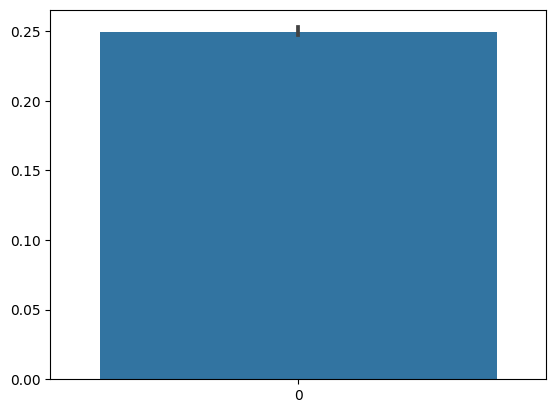

In [8]:
textos = list(train["Text"])
labels = list(train["Labels"])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(textos)


model_rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
scores = cross_validate(model_rf, X, labels, n_jobs=-1, return_estimator=True)
ax = sns.barplot(data=scores['test_score'])
feature_importance = pd.Series(sum([v.feature_importances_ for v in scores['estimator']])/len(scores['estimator']), vectorizer.vocabulary_).sort_values(ascending=False)
print(feature_importance[:20])

almighty             0.013641
tune                 0.010769
multimillionaires    0.009721
weinstein            0.009682
parking              0.008037
                       ...   
taxes                0.000000
free                 0.000000
ideas                0.000000
scott                0.000000
centers              0.000000
Length: 12196, dtype: float64


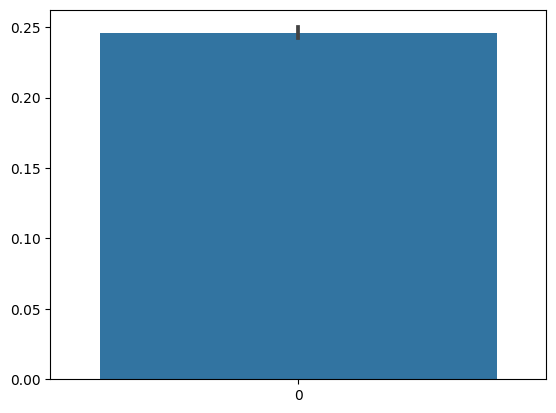

In [9]:
tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(textos)


model_rf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
scores = cross_validate(model_rf, X, labels, n_jobs=-1,return_estimator=True)
ax = sns.barplot(data=scores['test_score'])
feature_importance = pd.Series(sum([v.feature_importances_ for v in scores['estimator']])/len(scores['estimator']), tfidf_vec.vocabulary_).sort_values(ascending=False)
print(feature_importance[:20])

In [28]:
filter_by_tag = lambda tag: train[train['Text_Tag'].str.contains(tag, na=False)].reset_index().drop("index", axis=1)

# filter_by_tag("")

'abortion'